In [17]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
from shapely.geometry import Point, Polygon
from multiprocessing import Pool, cpu_count
from shapely.affinity import scale
from shapely.strtree import STRtree

import json
from rtree import index

import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [18]:
adata_dir = "data_level_1/adata_slide2/"
he_image_dir = "data_level_1/he_registered_old/"
pc_dir = "data_level_1/phenocycler_registered_new/"
polygon_dir  = "/data/projects/robin/segmentation/output-new-seg/segmentation_polygons.json"

with open(polygon_dir, 'r') as file:
    polygon_dict = json.load(file)

adata_with_domain = sc.read_h5ad("/data/projects/robin/segmentation/new-slide-glom-periglom-ps/adata_with_polygons.h5ad")

In [19]:
cell_names = [str(polygon_dict['geometries'][i]['cell']) for i in range(len(polygon_dict['geometries']))]
cell_coordinates = [polygon_dict['geometries'][i]['coordinates'][0] for i in range(len(polygon_dict['geometries']))]
cell_names = np.array(cell_names)
df_polygon = pd.DataFrame({
    'names' : cell_names,
    'coords' : cell_coordinates})
df_polygon.index = df_polygon['names']
df_polygon

,names,coords
names,,
185983,185983,"[[3714.5618, 20479.88], [3714.3374, 20482.264]..."
371966,371966,"[[7231.8833, 3040.58], [7232.0537, 3039.7822],..."
221120,221120,"[[7118.4053, 19706.914], [7115.494, 19704.934]..."
92533,92533,"[[1470.7107, 14148.667], [1470.7705, 14150.08]..."
76914,76914,"[[2689.5303, 12016.144], [2688.5042, 12016.396..."
...,...,...
300650,300650,"[[1215.121, 13696.862], [1213.2627, 13699.764]..."
150325,150325,"[[6032.6353, 14348.5], [6033.725, 14348.425], ..."
336545,336545,"[[7494.6553, 8513.94], [7494.7266, 8513.655], ..."


In [33]:
sample = 'X7'
adata = sc.read_h5ad(adata_dir + f'{sample}.h5ad')
he_image = plt.imread(he_image_dir + f'{sample}.tiff')

is_in_polygon = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'is_in_polygon']
adata.obs['is_in_polygon'] = list(is_in_polygon)

adata.shape

(12390, 480)

In [34]:
slide_id = adata.obs['Slide_ID'][0]
adata.uns['spatial'][slide_id]['images']['he_downscaled_aligned'] = he_image  
adata.uns['spatial'][slide_id]['scalefactors']['tissue_he_downscaled_aligned_scalef'] = 1
adata.uns['spatial'][slide_id]['scalefactors']['tissue_dapi_LEVEL1_cropped_scalef'] = 1

In [35]:
cell_name = [i.split('-')[1] for i in adata.obs.index]
adata.obs['cell_name'] = cell_name
adata = adata[adata.obs['cell_name'].isin(df_polygon['names'])]
adata.shape

(12390, 480)

In [36]:
df_polygon_i = df_polygon.loc[adata.obs['cell_name']]

In [37]:
ch = 9
adata.obs[f'Ki67'] = 0

pc_image = plt.imread(pc_dir + f"Phenocycler_Channel{(ch):02}_{sample}_Level2.ome.tiff")
w, h = pc_image.shape

In [38]:
x_shift = adata.obs['x'][0] - adata.obsm['spatial'][0, 0]
y_shift = adata.obs['y'][0] - adata.obsm['spatial'][0, 1]
x_shift, y_shift

(5521.0, 726.0)

In [39]:
adata.uns['spatial'][slide_id]['images']['Ki67'] = pc_image
adata.uns['spatial'][slide_id]['scalefactors']['tissue_Ki67_scalef'] = 1

In [40]:
adata = adata[adata.obs['is_in_polygon']]
adata = adata[adata.obs['celltype_l1'] == 'PEC']

In [41]:
##### Test
# i, j = 723, 478
# pc_image[i, j]

# coords = df_polygon_i.loc['62758', 'coords']
# coords = np.array(coords)
# coords[:,0] = coords[:,0] - x_shift
# coords[:,1] = coords[:,1] - y_shift
# coords

# polygon_obj = Polygon(coords)
# polygon_obj

# point = Point([i, j])
# polygon_obj = scale(polygon_obj, xfact=2, yfact=2, origin='centroid')
# polygon_obj.contains(point)

In [42]:
adata.obs['Ki67'] = 0
print(adata.shape)

pic_val_sum = {name: 0 for name in adata.obs.index}

for n, (idx, cell) in tqdm(enumerate(adata.obs.iterrows())):

    # if idx != adata.obs.index[ii]:
    #     continue
    
    cell_name = idx.split('-')[1]
    # print(adata.obsm['spatial'][n])

    coords = df_polygon_i.loc[cell_name, 'coords']
    coords = np.array(coords)
    coords[:,0] = coords[:,0] - x_shift
    coords[:,1] = coords[:,1] - y_shift
    polygon_obj = Polygon(coords)

    # print(coords)
    
    i_min, j_min = coords.min(axis=0) - 50
    i_max, j_max = coords.max(axis=0) + 50

    # print((i_min, i_max, j_min, j_max))

    i_min = 0 if i_min < 0 else i_min
    j_min = 0 if j_min < 0 else j_min
    i_max = h if i_max > w else i_max
    j_max = w if j_max > h else j_max
    
    for i in range(int(i_min), int(i_max)):
        for j in range(int(j_min), int(j_max)): 
            pic_val = pc_image[j, i]
            if pic_val > 0:
                point = Point(i, j)
                if polygon_obj.covers(point):
                    pic_val_sum[idx] += pic_val

adata.obs['Ki67'] = list(pic_val_sum.values())
(adata.obs['Ki67']).sum()

(152, 480)


152it [00:03, 42.26it/s]


2052

In [43]:
# adata.obs['Ki67'] = list(pic_val_sum.values())
# (adata.obs['Ki67']).sum()

In [44]:
# (adata.obs['Ki67'] > 0).sum() / len(adata.obs['Ki67'])

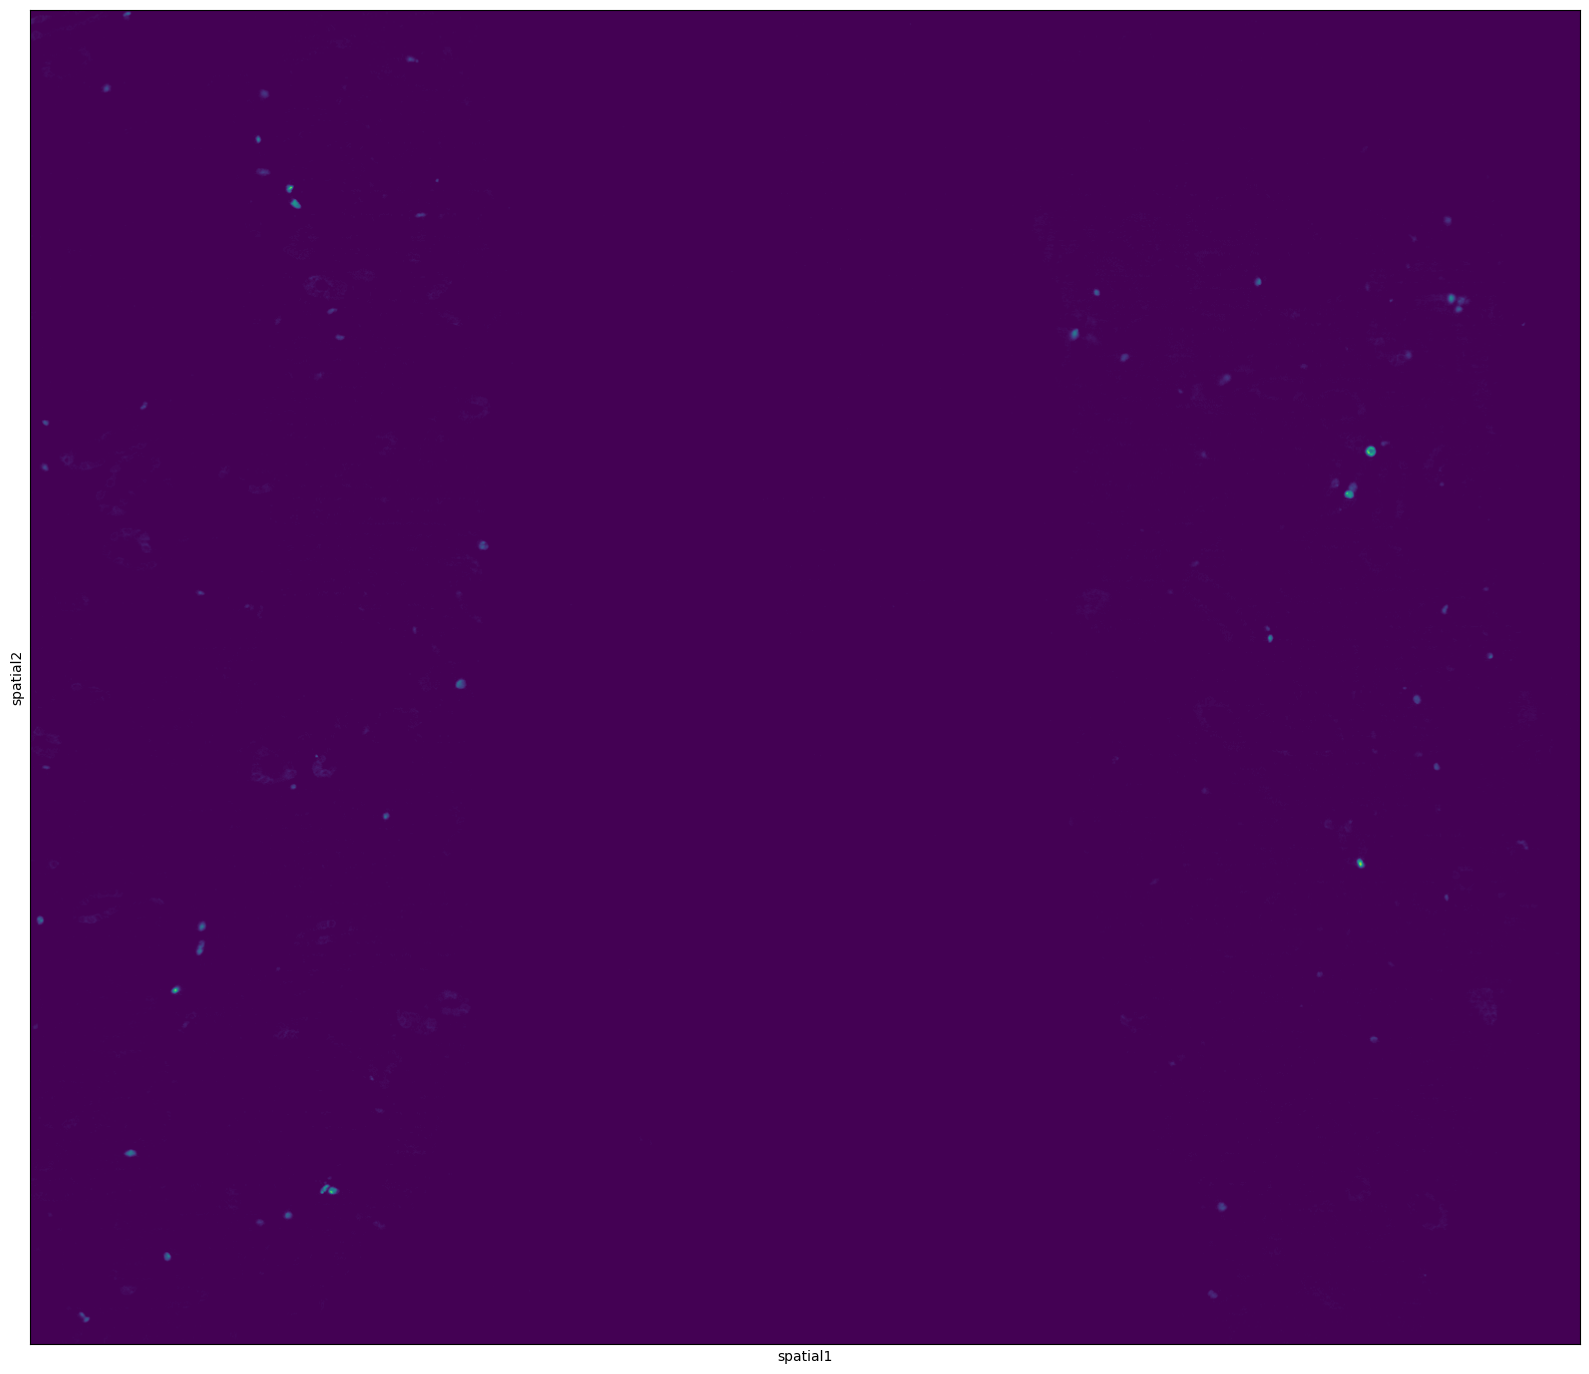

In [46]:
fig, ax = plt.subplots(figsize=(20, 20))
slide_id = adata.obs['Slide_ID'][0]

adata.obs['is_Ki67'] = ['yes' if i>0 else 'no' for i in adata.obs['Ki67']]

# adata.obs['cell'] = ['yes' if i==adata.obs.index[ii] else 'no' for i in adata.obs.index]

sc.pl.spatial(adata,
              library_id = slide_id,
              img_key = ['Ki67', 'dapi_LEVEL1_cropped', 'he_downscaled_aligned'][0],
              # color = 'Ki67',
              size = .3,
              ax = ax,
              cmap='seismic',
              show = True)

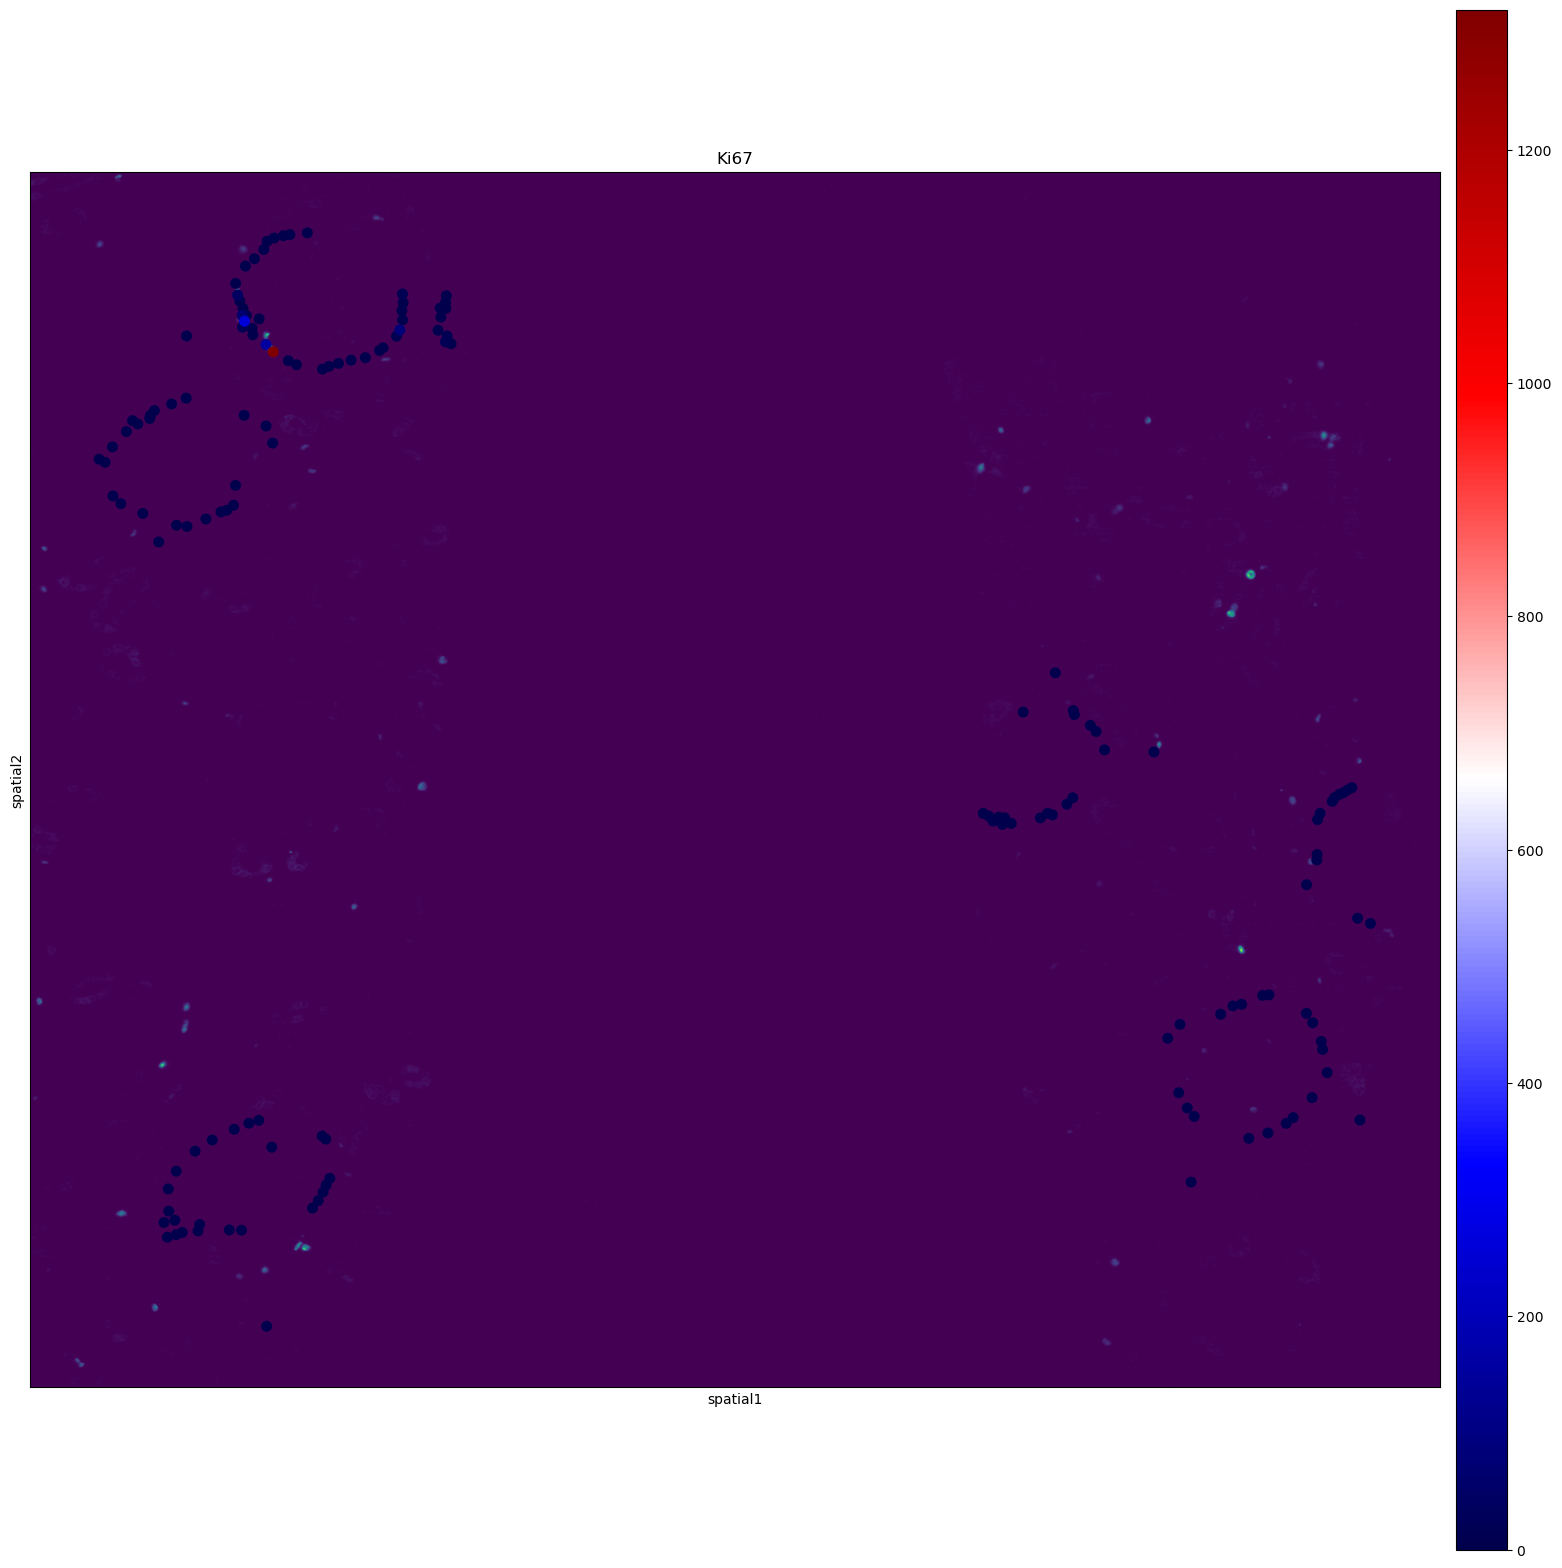

In [47]:
fig, ax = plt.subplots(figsize=(20, 20))
slide_id = adata.obs['Slide_ID'][0]

sc.pl.spatial(adata,
              library_id = slide_id,
              img_key = ['Ki67', 'dapi_LEVEL1_cropped', 'he_downscaled_aligned'][0],
              color = 'Ki67',
              size = .3,
              ax = ax,
              cmap='seismic',
              show = True)

In [32]:
# adata.write_h5ad(f"data_level_1/adata_slide2_{sample}_with_Ki67_v2.h5ad")

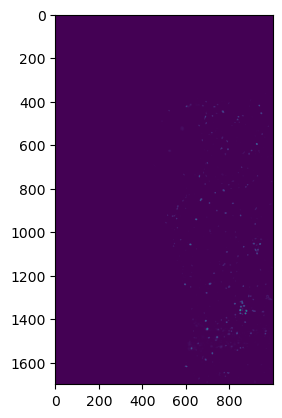

In [15]:
pc_image2 = pc_image.copy()
plt.imshow(pc_image2[0: 1700, 0:1000])

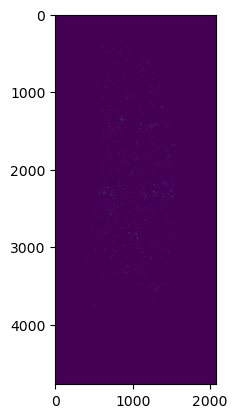

In [16]:
plt.imshow(pc_image2)

In [116]:
adata_dir = "data_level_1/adata_slide2/"
he_image_dir = "data_level_1/he_registered_old/"
pc_dir = "data_level_1/phenocycler_registered/"

for sample in ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']:
    print(sample)
    adata = sc.read_h5ad('data_level_1/' + f"adata_slide2_{sample}_with_Ki67_v1.h5ad")
    
    if sample == 'X1':
        adata_all = adata
    else:
        adata_all = adata_all.concatenate(adata) 
    print(adata_all.shape)

X1
(86811, 480)
X2
(116087, 480)
X3
(168976, 480)
X4
(199596, 480)
X5
(231888, 480)
X6
(277212, 480)
X7
(289602, 480)


In [56]:
adata_all.write_h5ad("data_level_1/adata_slide2_with_Ki67_noX8_v1.h5ad")

NameError: name 'adata_all' is not defined

In [901]:
# show dapi
# LEVEL = 1
# ID = adata.obs.Slide_ID.unique()[0]
# scale_factor = adata.uns["spatial"][ID]["scalefactors"][f"tissue_dapi_LEVEL{LEVEL}_scalef"]
# dapi = adata.uns["spatial"][ID]["images"][f"dapi_LEVEL{LEVEL}"+"_cropped"]
# dapi.shape
# adata.obs['dapi'] = [dapi[int(j), int(i)] for i, j in adata.obsm["spatial"]]
# adata.obsm["spatial"].min(axis=0), adata.obsm["spatial"].max(axis=0) + 350

In [903]:
# adata.uns['spatial'][slide_id]['images'].keys()

In [118]:
adata_all.obs['sample']

cell_CR9fbacb852-172697-0-0-0-0-0-0    x1
cell_CR9fbacb852-183840-0-0-0-0-0-0    x1
cell_CR9fbacb852-183965-0-0-0-0-0-0    x1
cell_CR9fbacb852-184398-0-0-0-0-0-0    x1
cell_CR9fbacb852-185040-0-0-0-0-0-0    x1
                                       ..
cell_CR9fbacb852-344135-1              x7
cell_CR9fbacb852-344237-1              x7
cell_CR9fbacb852-344280-1              x7
cell_CR9fbacb852-344416-1              x7
cell_CR9fbacb852-344461-1              x7
Name: sample, Length: 289602, dtype: category
Categories (7, object): ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']

In [2]:
adata_all = sc.read_h5ad("data_level_1/adata_slide2_with_Ki67_noX8_v1.h5ad")

In [7]:
adata_all = adata_all[adata_all.obs['label'] != 'gbm']

In [8]:
(adata_all.obs['celltype_l1'] == 'PEC').sum()

3803

In [9]:
# ((adata_all.obs['celltype_l1'] == 'PEC') & (adata_all.obs['label'] == disease_set[3])).sum()

In [10]:
adata_all.obs.columns

Index(['x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation',
       'area', 'avg_confidence', 'avg_assignment_confidence',
       'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area',
       'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob',
       'Slide_ID', 'sample', 'label', 'cell_name', 'Ki67', 'batch'],
      dtype='object')

In [11]:
from scipy.stats import pearsonr
import scipy.sparse

adata = adata_all[adata_all.obs['celltype_l1'] == 'PEC']

In [12]:
gene_list = ['PDGFA', 'PDGFB', 'PDGFRB']

cor = []
for i in gene_list:
    a = np.array(adata[:, i].X.todense()).ravel()
    b = np.array(adata.obs['Ki67'])
    c,p = pearsonr(a,b)
    cor.append(c)
cor

[-0.006470734021304744, 0.007023616839445757, -0.004050029820066682]

In [13]:
disease_set = adata_all.obs['label'].unique()
disease_set

['ctrl', 'anca', 'sle']
Categories (3, object): ['anca', 'ctrl', 'sle']

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
disease_order = ['ctrl', 'sle', 'anca', 'gbm']
df = adata.obs
df['label'] = pd.Categorical(df['label'], categories=disease_order, ordered=True)

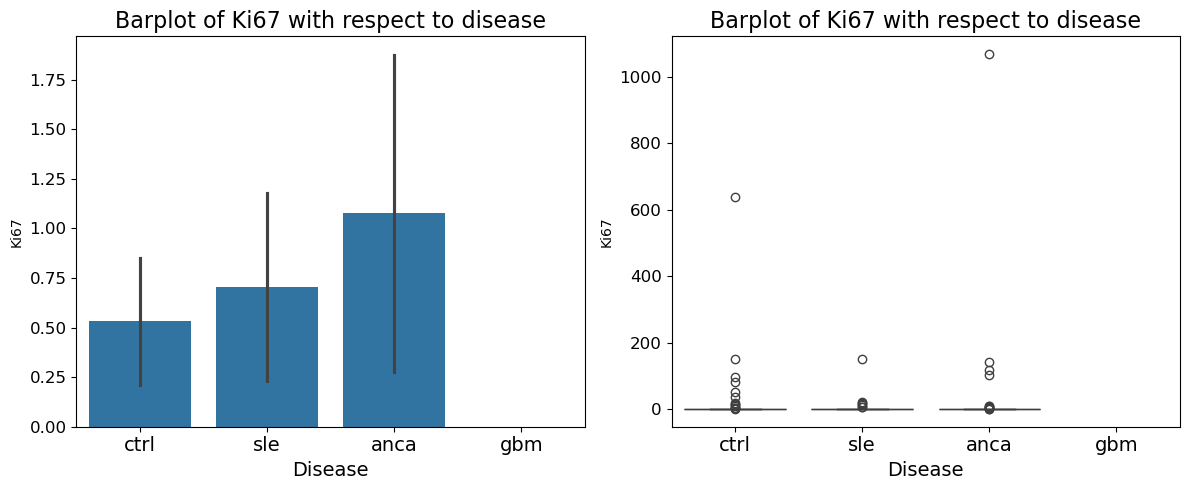

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Ki67'
sns.barplot(x='label', y=ch, data=df, ax=axes[0], errorbar='se', order=disease_order)
axes[0].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x='label', y=ch, data=df, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

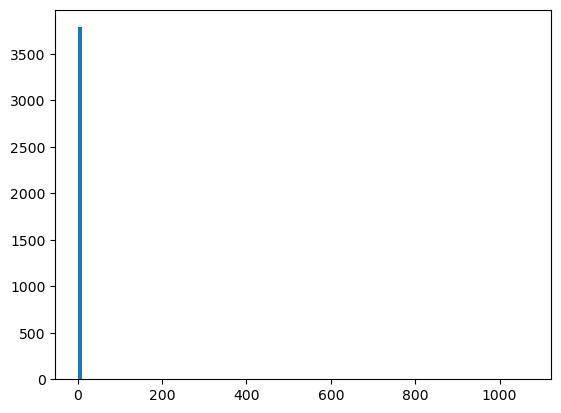

In [17]:
plt.hist(df[ch], 100);
# plt.ylim([0, 10])

In [18]:
import seaborn as sns

(0.0, 50.0)

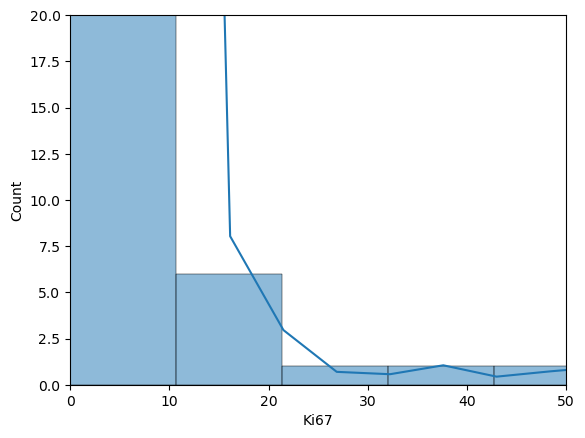

In [19]:
# plt.hist(df[ch], 100)
# plt.ylim([0, 20])
# plt.xlim([0, 200])

sns.histplot(df[ch], bins= 100,kde = True)
plt.ylim([0, 20])
plt.xlim([0, 50])

In [77]:
# df_new = df.loc[df[ch] > 10]

# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ch = 'Ki67'
# sns.barplot(x='label', y=ch, data=df_new, ax=axes[0], errorbar='se', order=disease_order)
# axes[0].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
# axes[0].set_xlabel('Disease', fontsize=14)
# # axes[0].set_ylabel('x', fontsize=14)
# axes[0].tick_params(axis='x', labelsize=14)
# axes[0].tick_params(axis='y', labelsize=12)

# sns.boxplot(x='label', y=ch, data=df_new, ax=axes[1], order=disease_order)
# axes[1].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
# axes[1].set_xlabel('Disease', fontsize=14)
# # axes[1].set_ylabel('x', fontsize=14)
# axes[1].tick_params(axis='x', labelsize=14)
# axes[1].tick_params(axis='y', labelsize=12)


# plt.tight_layout()
# plt.show()

In [101]:
df = df.loc[df['Ki67'] < 200]

In [20]:
df = df.reset_index(drop=True)
# df.insert(1, 'Ki67_prc', 0)
th = 15
df.loc[:, 'Ki67_prc'] = [1.0 if i>th else 0.0 for i in df['Ki67']]
df['Ki67_prc'].sum()

15.0

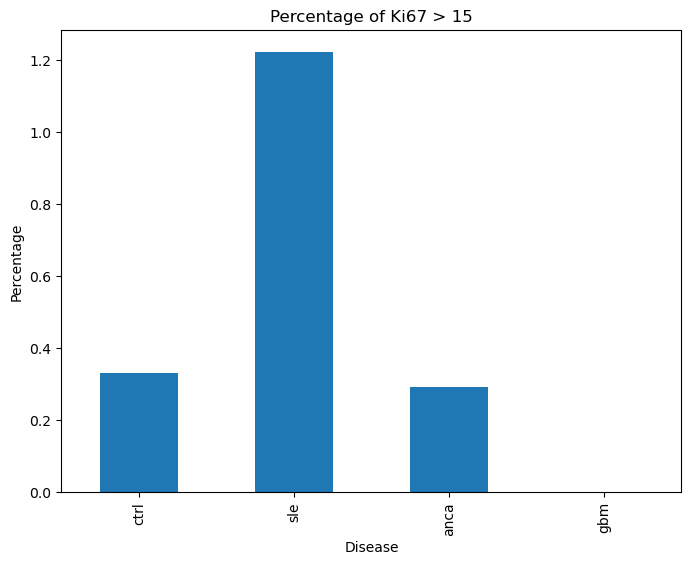

In [21]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Ki67_prc'
percent = df.groupby('label')[ch].mean() * 100
percent = percent.reindex(disease_order)
percent.plot(kind='bar', figsize=(8, 6))

plt.title(f'Percentage of Ki67 > {th}')
plt.xlabel('Disease')
plt.ylabel('Percentage')
plt.show()

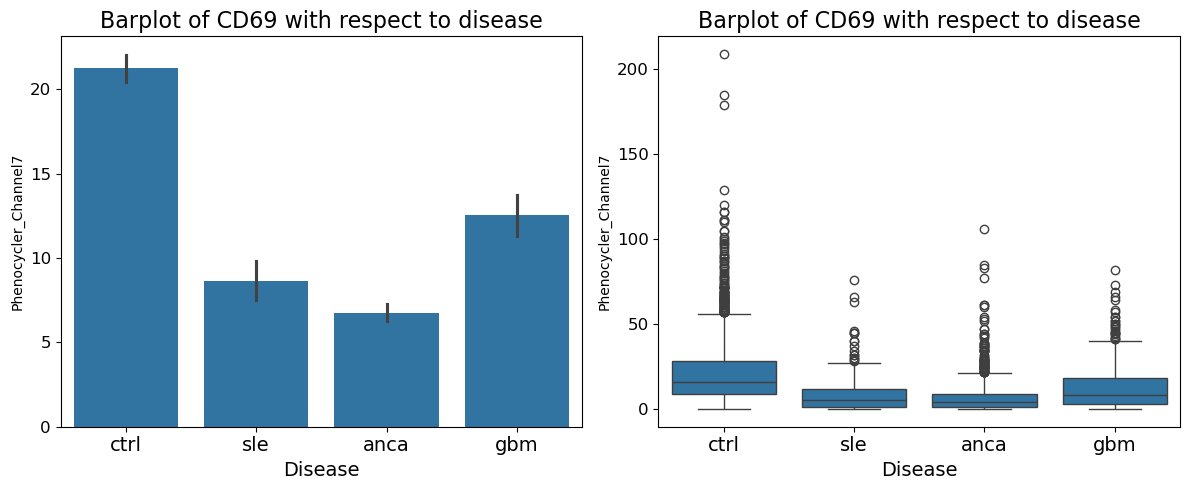

In [467]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Phenocycler_Channel7'
sns.barplot(x='label', y=ch, data=df, ax=axes[0], order=disease_order)
axes[0].set_title('Barplot of CD69 with respect to disease', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x='label', y=ch, data=df, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of CD69 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

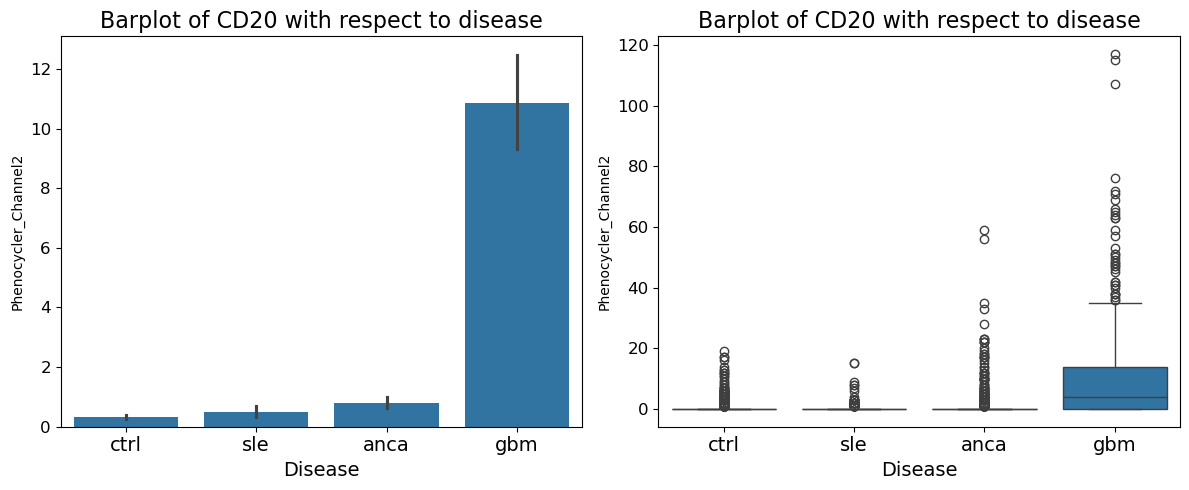

In [214]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Phenocycler_Channel2'
sns.barplot(x='label', y=ch, data=df, ax=axes[0], order=disease_order)
axes[0].set_title('Barplot of CD20 with respect to disease', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x='label', y=ch, data=df, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of CD20 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

In [721]:
adata_robin = sc.read_h5ad("/data/projects/robin/robin_xenium_cgn_from_epyc/seperate_dapi_samples/with_protein.h5ad")

In [722]:
# adata_robin = adata_robin[adata_robin.obs['Sample_num'] != 'X7']
adata_robin = adata_robin[adata_robin.obs['celltype_l1'] == 'PEC']

In [723]:
disease_order = ['Cntrl', 'Sle', 'Anca', 'Gbm']
df = adata_robin.obs
df['label'] = pd.Categorical(df['Disease'], categories=disease_order, ordered=True)

In [724]:
df['label'] = pd.Categorical(df['Disease'], categories=disease_order, ordered=True)

(0.0, 10.0)

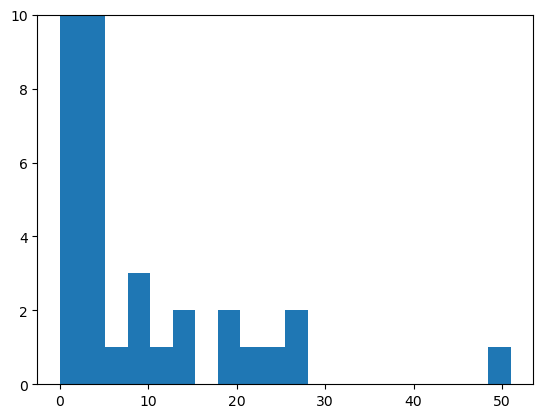

In [725]:
ch = 'Ki67_p'
plt.hist(df[ch], 20)
plt.ylim([0, 10])

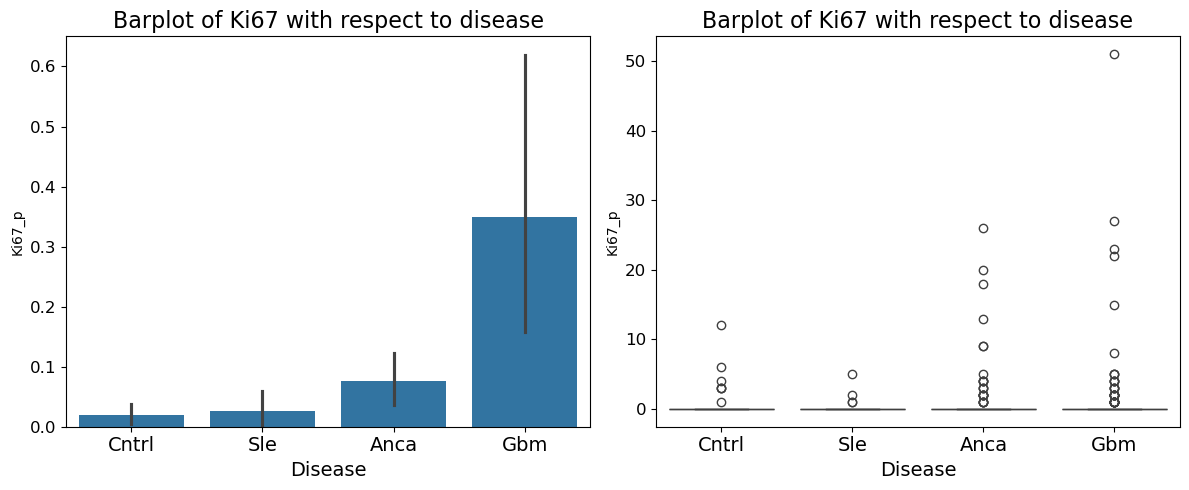

In [726]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Ki67_p'
sns.barplot(x='Disease', y=ch, data=df, ax=axes[0], order=disease_order)
axes[0].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x='Disease', y=ch, data=df, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

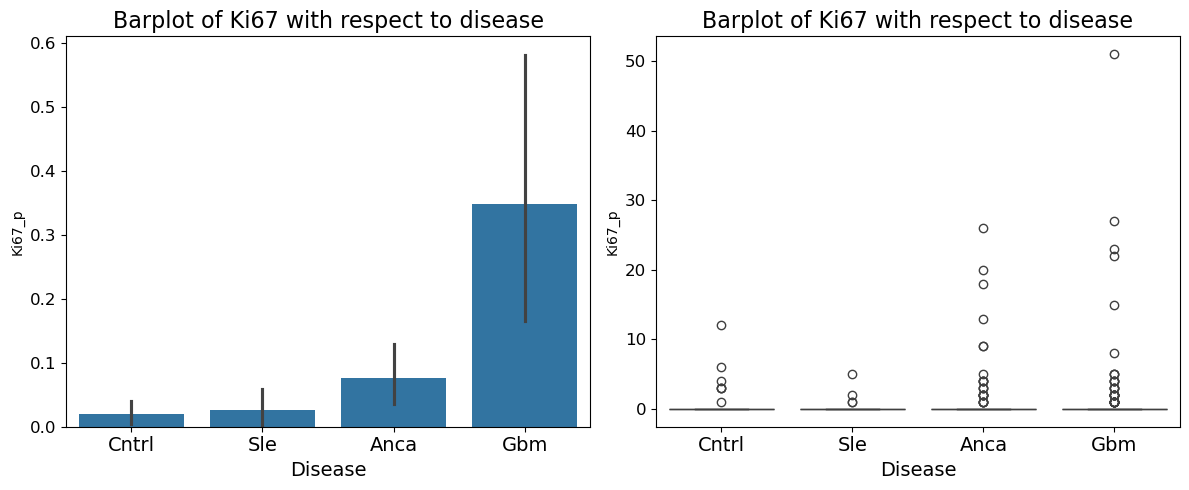

In [727]:
df_new = df.loc[df['Ki67_p'] >= 0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Ki67_p'
sns.barplot(x='Disease', y=ch, data=df_new, ax=axes[0], order=disease_order)
axes[0].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x='Disease', y=ch, data=df_new, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

In [730]:
df = df.reset_index(drop=True)
df.loc[:, 'Ki67_prc'] = [1.0 if i>6 else 0.0 for i in df['Ki67_p']]
df['Ki67_prc'].sum()

13.0

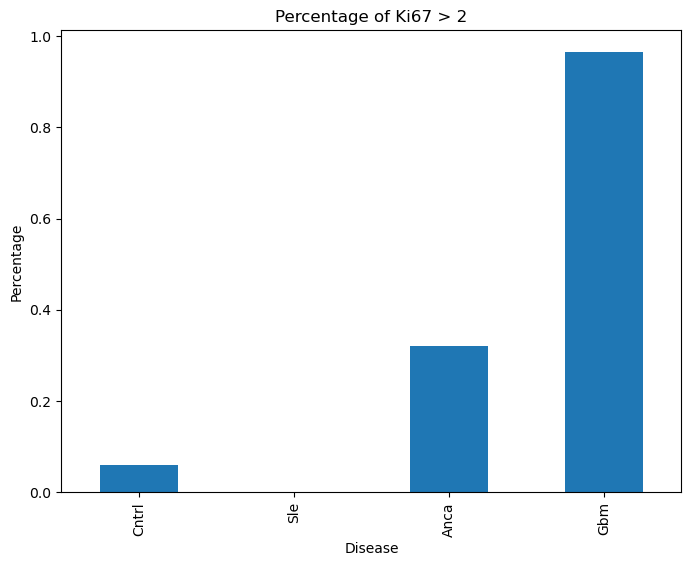

In [732]:
ch = 'Ki67_prc'
percent = df.groupby('Disease')[ch].mean() * 100
percent = percent.reindex(disease_order)
percent.plot(kind='bar', figsize=(8, 6))

plt.title('Percentage of Ki67 > 2')
plt.xlabel('Disease')
plt.ylabel('Percentage')
plt.show()

In [548]:
adata_all.obs.loc[adata_all.obs['label'] == 'sle', 'sample']

cell_CR9fbacb852-12121-1-0    X7
cell_CR9fbacb852-13226-1-0    X7
cell_CR9fbacb852-13244-1-0    X7
cell_CR9fbacb852-13263-1-0    X7
cell_CR9fbacb852-13268-1-0    X7
                              ..
cell_CR9fbacb852-344264-1     X8
cell_CR9fbacb852-344326-1     X8
cell_CR9fbacb852-344371-1     X8
cell_CR9fbacb852-344671-1     X8
cell_CR9fbacb852-344894-1     X8
Name: sample, Length: 26634, dtype: category
Categories (8, object): ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']

In [858]:
i = np.where(cell_names == '344894')[0].item()
poly_i = np.array(cell_coordinates[i])
poly_i[:,0], poly_i[:,1]

(array([3521.6711, 3522.5667, 3519.4448, 3518.621 , 3518.3726, 3519.4453,
        3519.8542, 3521.6711]),
 array([1183.9215, 1183.3866, 1181.8112, 1180.7463, 1182.4324, 1183.1168,
        1183.2418, 1183.9215]))

In [841]:
adata_all.obs

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,Phenocycler_Channel6,Phenocycler_Channel7,Phenocycler_Channel8,Phenocycler_Channel9,Phenocycler_Channel10,Phenocycler_Channel11,Phenocycler_Channel12,Phenocycler_Channel13,batch,cell_name
cell_CR9fbacb852-172697-0-0-0-0-0-0-0,5686.630300,16243.587750,32.710325,4,8,0.3695,3.021,21.650,0.9724,0.9025,...,0,0,0,0,0,0,0,0,0,172697
cell_CR9fbacb852-183840-0-0-0-0-0-0-0,5533.867400,17797.181667,28.890549,3,6,0.8171,4.300,7.343,0.9859,0.9700,...,0,0,0,0,0,0,0,0,0,183840
cell_CR9fbacb852-183965-0-0-0-0-0-0-0,5544.457950,17818.821750,27.178570,3,8,2.2230,2.835,3.599,0.9743,0.9775,...,0,0,0,0,0,0,0,0,0,183965
cell_CR9fbacb852-184398-0-0-0-0-0-0-0,7113.689200,16393.493100,23.298814,4,10,1.3270,1.694,7.536,0.9939,0.9780,...,0,1,0,0,0,0,1,0,0,184398
cell_CR9fbacb852-185040-0-0-0-0-0-0-0,7705.488675,16117.277875,23.637515,4,12,1.7790,1.445,6.745,0.9983,0.9950,...,0,1,0,0,0,0,2,0,0,185040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_CR9fbacb852-344264-1,2479.081464,3356.340695,39.132713,4,22,1.1450,5.912,19.220,0.9983,0.7436,...,0,4,4,0,0,49,0,0,1,344264
cell_CR9fbacb852-344326-1,3378.595655,985.457752,42.317890,1,29,0.4470,1.583,64.880,0.9891,0.7048,...,0,0,0,0,0,4,0,0,1,344326
cell_CR9fbacb852-344371-1,3434.533961,874.129657,40.304167,4,28,0.5554,2.315,50.410,0.9917,0.7014,...,0,0,0,0,0,6,0,0,1,344371
cell_CR9fbacb852-344671-1,2246.205632,1924.905336,39.431705,1,22,0.7353,3.803,29.920,0.9965,0.6064,...,0,1,1,0,0,0,1,0,1,344671


In [860]:
i, j = adata_all.obsm["spatial"][0]

In [846]:
pc_image[int(j), int(i)]

0

In [863]:
int(np.round(i))

722

In [19]:
a = None
a != None

False